## Summary
Based on NBA career statistics from all Basketball Hall of Fame inductees, a predictive model is used to calculate the probability of hall of fame induction for all active and recently-retired players.

## Introduction
Since 1959, the Naismith Memorial Basketball Hall of Fame has inducted almost 400 coaches, players, referees, contributors, and teams. It honors individuals who have shown exceptional skill at basketball, all-time great coaches, referees, and other major contributors to the sport (broadcasters, journalists, etc.). 

Several people have been inducted multiple times, either as players/coaches or as coaches/contributors. A players does have to play in the NBA to be inducted, as career achievements in college, WNBA, international teams, and other platforms are considered. For a player to be eligible on the ballot, he or she must be fully retired for at least three years. They can also become inducted as a part of a historically-significant team, such as the 1992 US men's Olympic basketball team - widely regarded as the greatest team ever assembled in any sports.

To analyze which current and recently-retired players will become inducted into the hall of fame in the future, I created various models based on almost 60 years of previous data.

## Data & Methods
Based on the data I web scraped from [Basketball Reference](https://www.basketball-reference.com/), I created a database of all historical ABA/NBA players since 1947 who played at least one game. For these players, I retrieved the following stats:

- name: full name of player, first name and last name
- active_from: year started playing for the NBA
- active_to: last year playing for the NBA (2018 is still active)
- career_length: seasons played in league (disregards if retired during)
- birth_date: datetime variable, date of birth
- position: five positions classification - most common approach in modern ear
- trad_position: three positions classification - traditional approach of describing positions
- ppg: float variable, total points per game
- trb: float variable, total rebounds per game
- ast: float variable, total assists per game
- per: float variable, [player efficiency rating](https://www.basketball-reference.com/about/per.html)
- ws: float variable, [win shares](https://www.basketball-reference.com/about/ws.html)
- height_inches: float variable, height measured in inches
- weight: float variable, weight measured in pounds
- shooting hand: prefered shooting hand
- hof: 0 or 1, inducted into Naismith Memorial Basketball Hall of Fame as player
    * 0 if inducted as coach, contributor, etc.
- college: college basketball programs of participation
- hs_name: name of high school attended
- hs_city: city of high school location
- hs_state: state or country (if foreign player) of high school
- url: player page in www.basketball-reference.com

Here is a preview of the data:

In [132]:
players.head()

,name,active_from,active_to,career_length,birth_date,position,trad_position,ppg,trb,ast,...,ws,height_inches,weight,shooting_hand,hof,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,4,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,...,4.8,82.0,240.0,Right,0.0,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,9,1946-04-07,Power Forward,Forward,9.0,8.0,1.2,...,17.5,81.0,235.0,Right,0.0,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,19,1947-04-16,Center,Center,24.6,11.2,3.6,...,273.4,86.0,225.0,Right,1.0,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,10,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,...,25.2,73.0,162.0,Right,0.0,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,5,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,...,3.5,78.0,223.0,Right,0.0,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


Using all the counting statistics, such as career per-game statstics and advanced stats, I created four models to predict a player's hall of fame induction probability. 

With these inputs and outputs, I created four models:
Logistic regression
Decision tree and random forest classifier
Naive Bayes classifier
Support vector regression (SVM)

The models were trained and tested on hall of fame data from 1947-2015, and then made predictions for current players and players retired since 2015.

## Limitations

**Careers outside of NBA**: Players who achieved college stardom or legendary international careers, but did not have the same level of success in the NBA, are just as eligible for the hall of fame. For example, Arvydas Sabonis was inducted in 2011 for his legendary career in the European stage, despite only playing seven seasons in the NBA and averaging 12 points-per-game. 


**Active players**: We are using data gathered up to 2018 season, meaning we are disregarding future career achievements. Essentially, we are asking the question "If this player retired today, will he be elected into the hall of fame?".

**Narrative**: Players who are considered pioneers of the game are more likely to be inducted, while those who have 'damaged the integrity of the game of basketball' are less likely to be inducted. For example, Gilbert Arenas averaged 20.7 points-per-game and received multiple accolades throughout his career, but he is unlikely to be ever nominated due to a handgun violations incident during the 2009-2010 season. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set_style('whitegrid')
from bs4 import BeautifulSoup, SoupStrainer
import sys, string, requests, datetime, time
%matplotlib inline

In [2]:
players = pd.read_csv('Tables/players.csv') # this csv file is taken from web scraped data from Baskeball-Reference
players.head()

,name,active_from,active_to,career_length,birth_date,position,trad_position,ppg,trb,ast,...,ws,height_inches,weight,shooting_hand,hof,college,hs_name,hs_city,hs_state,url
0,Alaa Abdelnaby,1991,1995,4,1968-06-24,Power Forward,Forward,5.7,3.3,0.3,...,4.8,82.0,240.0,Right,0.0,Duke University,Bloomfield,Bloomfield,New Jersey,/players/a/abdelal01.html
1,Zaid Abdul-Aziz,1969,1978,9,1946-04-07,Power Forward,Forward,9.0,8.0,1.2,...,17.5,81.0,235.0,Right,0.0,Iowa State University,John Jay,Brooklyn,New York,/players/a/abdulza01.html
2,Kareem Abdul-Jabbar,1970,1989,19,1947-04-16,Center,Center,24.6,11.2,3.6,...,273.4,86.0,225.0,Right,1.0,"University of California, Los Angeles",Power Memorial,New York,New York,/players/a/abdulka01.html
3,Mahmoud Abdul-Rauf,1991,2001,10,1969-03-09,Point Guard,Guard,14.6,1.9,3.5,...,25.2,73.0,162.0,Right,0.0,Louisiana State University,Gulfport,Gulfport,Mississippi,/players/a/abdulma02.html
4,Tariq Abdul-Wahad,1998,2003,5,1974-11-03,Shooting Guard,Guard,7.8,3.3,1.1,...,3.5,78.0,223.0,Right,0.0,"University of Michigan, San Jose State University",Lycee Aristide Briand,Evreux,France,/players/a/abdulta01.html


In [3]:
#hof_not_eligible = players[players['active_to'] > 2015]
players_hof = players[players['hof'] == 1.0]
players_not_hof = players[players['hof'] == 0]

## Data visualization

### Individual statistics

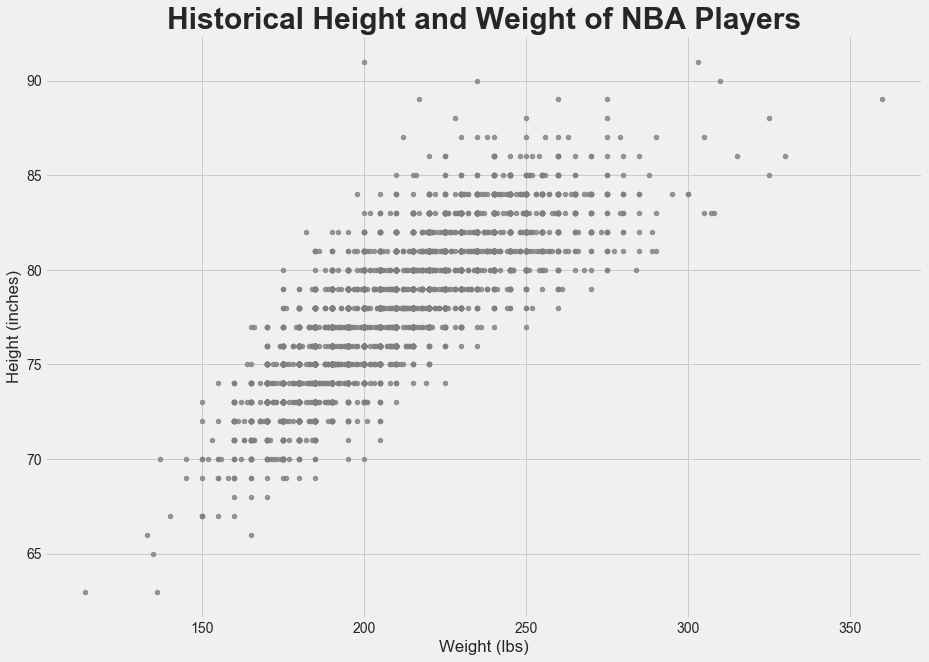

In [4]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))

ax = sns.regplot(x='weight', y='height_inches', data=players, 
                 color='grey', fit_reg=False, scatter_kws={"s": 20})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')
plt.title('Historical Height and Weight of NBA Players', fontsize=30, fontweight="bold")

plt.savefig('all-graphs/height_weight.png')

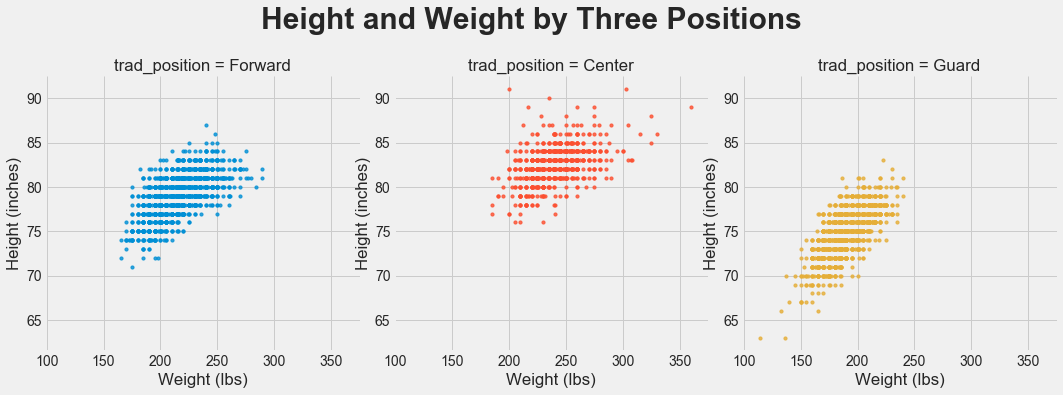

In [5]:
plt.style.use('fivethirtyeight')

ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='trad_position', hue='trad_position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

hw_subtitle = plt.suptitle('Height and Weight by Three Positions', fontsize=30, fontweight="bold", y=1.1)

plt.savefig('all-graphs/height_weight_3pos.png', bbox_inches='tight',bbox_extra_artists=[hw_subtitle])

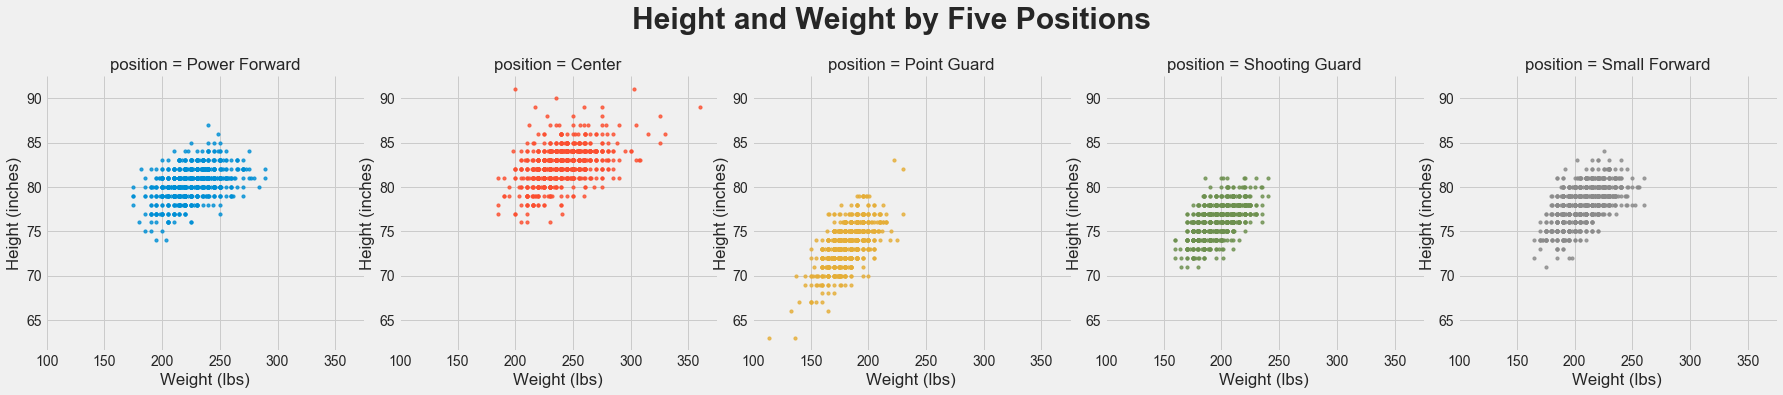

In [6]:
plt.style.use('fivethirtyeight')

ax = sns.lmplot(x="weight", y="height_inches", data=players, 
               col='position', hue='position',
               x_jitter=.1, fit_reg=False, scatter_kws={"s": 10})

ax.set(xlabel='Weight (lbs)', ylabel='Height (inches)')

hw_subtitle = plt.suptitle('Height and Weight by Five Positions', fontsize=30, fontweight="bold", y=1.1)

plt.savefig('all-graphs/height_weight_5pos.png', bbox_inches='tight',bbox_extra_artists=[hw_subtitle])

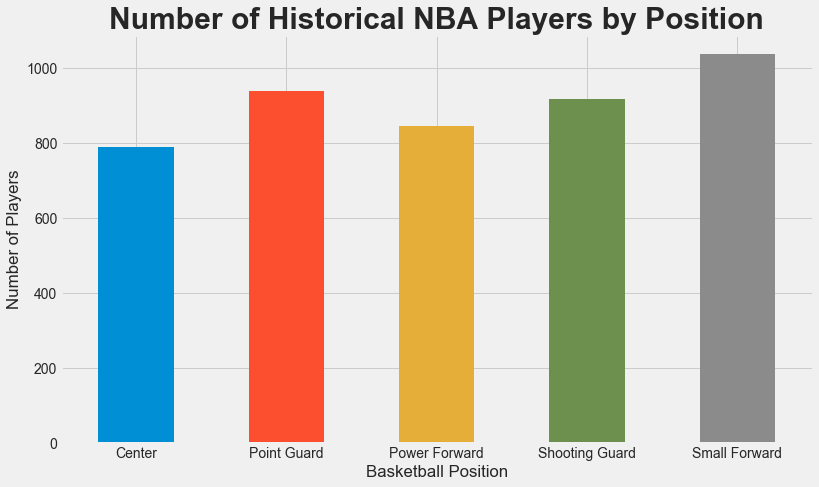

In [7]:
plt.style.use('fivethirtyeight')

ax = players.groupby('position').count()['trad_position'].plot.bar(figsize=(12,7), rot=0)
ax.set(xlabel='Basketball Position', ylabel='Number of Players')

plt.title('Number of Historical NBA Players by Position', fontsize=30, fontweight="bold")

plt.savefig('all-graphs/num_pos.png')

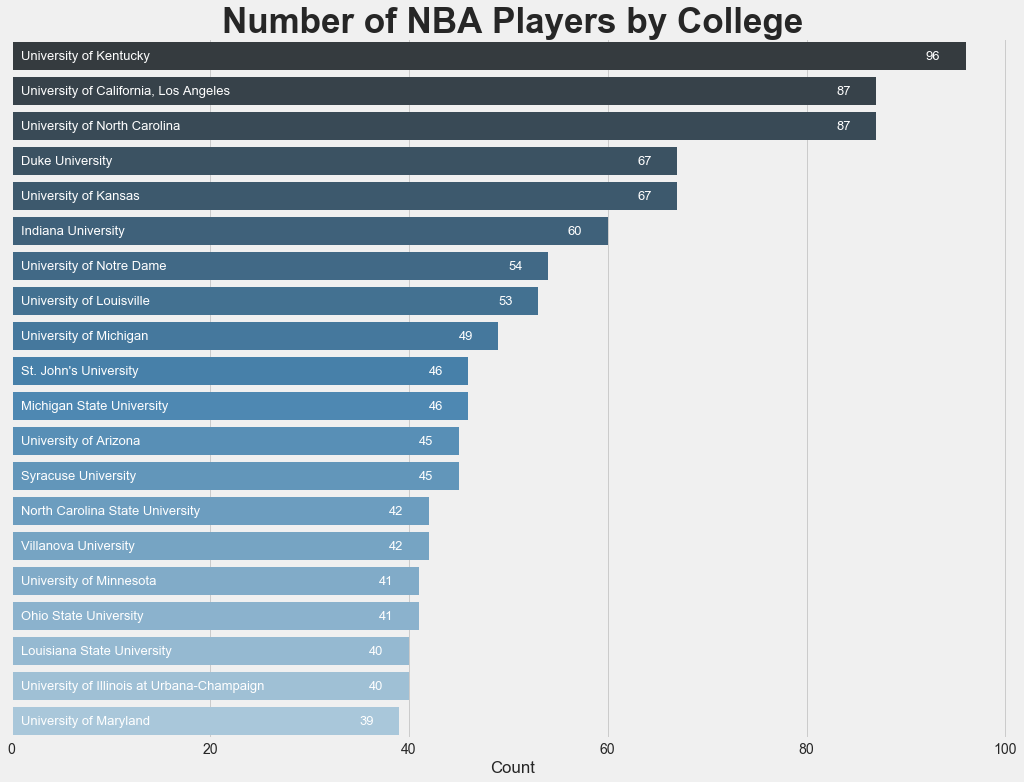

In [8]:
plt.style.use('fivethirtyeight')

top_colleges = players['college'].value_counts()[:20]
top_colleges_df = pd.DataFrame(top_colleges)
top_colleges_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_colleges_df.index, data=top_colleges_df, palette="Blues_d")
plt.title('Number of NBA Players by College', fontsize=35, fontweight='bold')
plt.gca().set_yticks([]);

for num in range(len(top_colleges)):
    plt.text(top_colleges[num]-4, num, top_colleges[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_colleges.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_colleges.png')

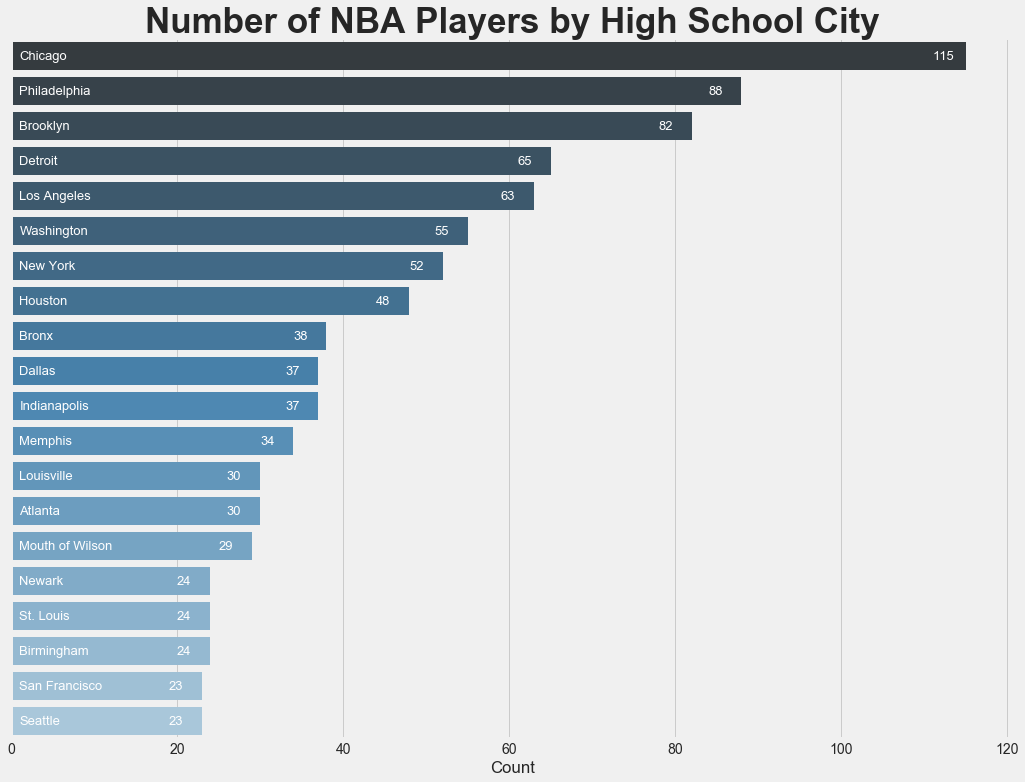

In [9]:
plt.style.use('fivethirtyeight')

top_hs_cities = players['hs_city'].value_counts()[:20]
top_hs_cities_df = pd.DataFrame(top_hs_cities)
top_hs_cities_df.columns = ['Count']

plt.figure(figsize=(16,12))
sns.barplot(x='Count', y=top_hs_cities_df.index, data=top_hs_cities_df, palette="Blues_d")
plt.title('Number of NBA Players by High School City', fontsize=35, fontweight="bold")
plt.gca().set_yticks([]);

for num in range(len(top_hs_cities)):
    plt.text(top_hs_cities[num]-4, num, top_hs_cities[num], color='white', size=13, verticalalignment='center')
    plt.text(1, num, top_hs_cities.index[num], color='white', size=13, verticalalignment='center')
    
plt.savefig('all-graphs/top_hs_city.png')

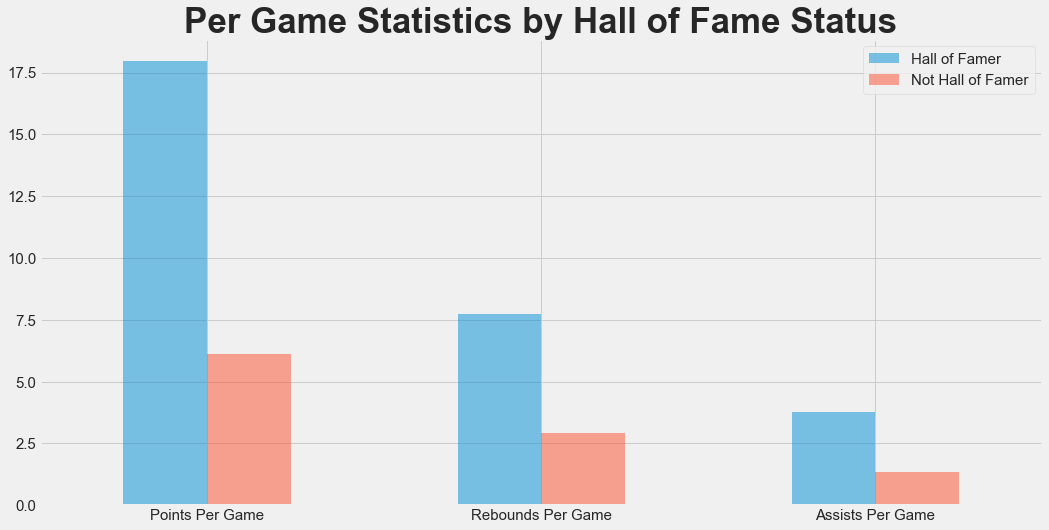

In [10]:
plt.style.use('fivethirtyeight')

sort_by_hof = players.groupby('hof')['ppg', 'trb', 'ast'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'ppg': 'Points Per Game', 
                                  'trb': 'Rebounds Per Game', 
                                  'ast': 'Assists Per Game'},
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Per Game Statistics by Hall of Fame Status', fontsize=35, fontweight="bold")


plt.savefig('all-graphs/hof_stats.png')

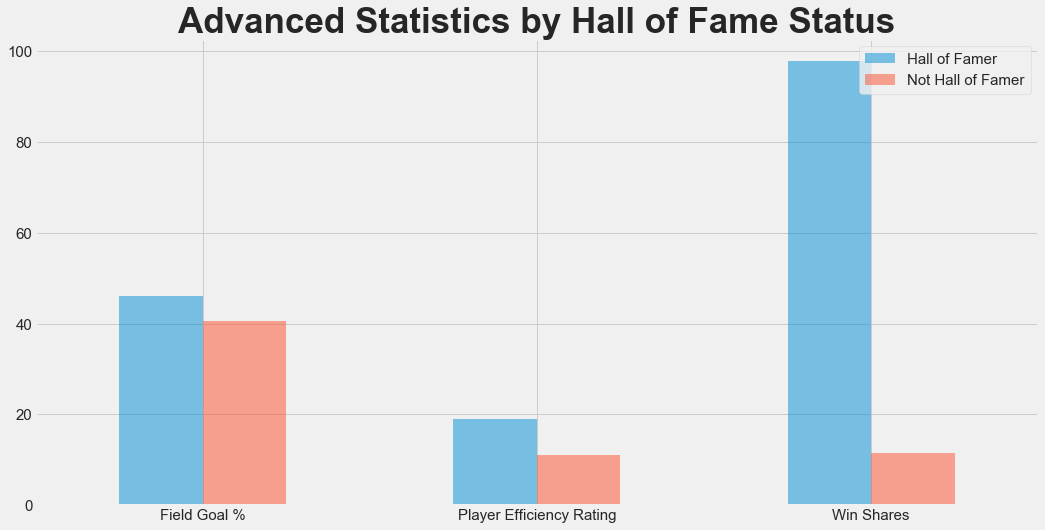

In [11]:
plt.style.use('fivethirtyeight')

sort_by_hof = players.groupby('hof')['fgp', 'per', 'ws'] # statistics grouped by hof status
sort_by_hof = sort_by_hof.mean().transpose()  # average stats, transposed for graphing purposes
sort_by_hof = sort_by_hof.rename({'fgp': 'Field Goal %',
                                  'per': 'Player Efficiency Rating',
                                  'ws': 'Win Shares'},
                                   axis='index')
sort_by_hof = sort_by_hof.rename({1: 'Hall of Famer', 
                                  0: 'Not Hall of Famer'}, 
                                  axis='columns')
sort_by_hof = sort_by_hof[sort_by_hof.columns[::-1]] # reverse column order
sort_by_hof.plot(kind='bar', figsize=(16,8), alpha=0.5, rot=0)

plt.legend(prop={'size':15}, frameon=True, loc=1)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title('Advanced Statistics by Hall of Fame Status', fontsize=35, fontweight="bold")


plt.savefig('all-graphs/hof_adv_stats.png')

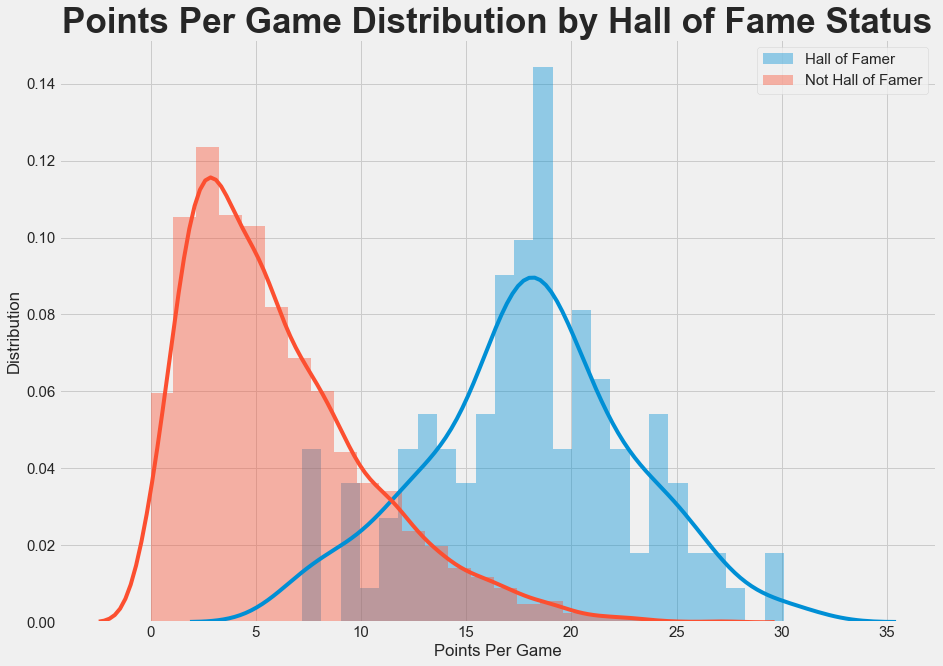

In [12]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['ppg'], bins=25, label='Hall of Famer')
sns.distplot(players_not_hof['ppg'].fillna(0), bins=25, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Points Per Game")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Points Per Game Distribution by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_ppg.png')

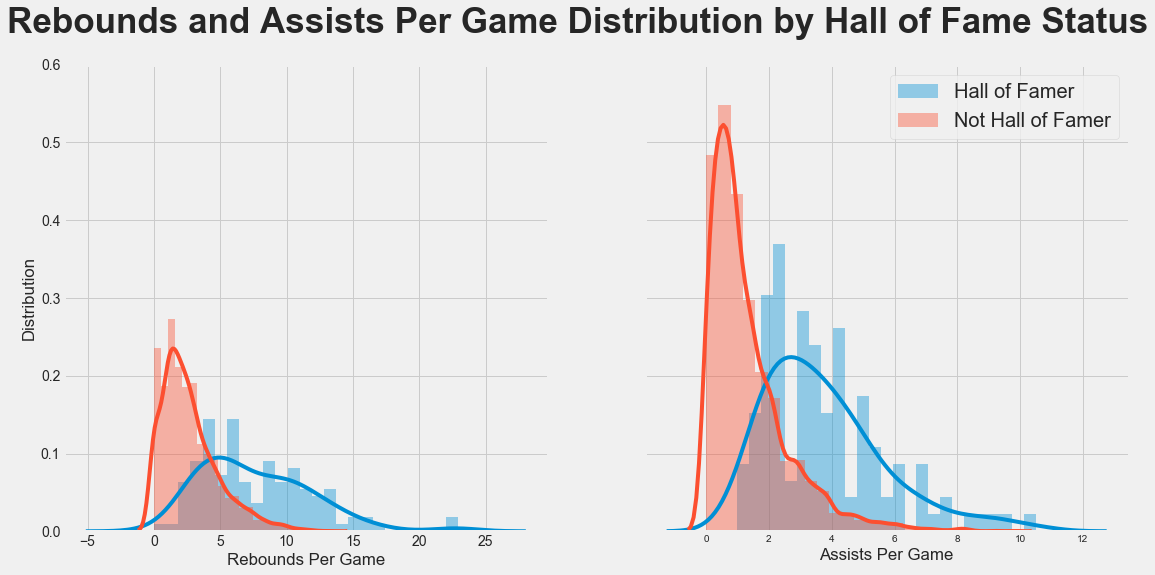

In [13]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(17,8))

sns.distplot(players_hof['trb'].fillna(0), bins=25, label='Hall of Famer', ax=ax1)
sns.distplot(players_not_hof['trb'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax1)
ax1.set(xlabel='Rebounds Per Game', ylabel='Distribution')
plt.xticks(fontsize=27)

sns.distplot(players_hof['ast'].fillna(0), bins=25, label='Hall of Famer', ax=ax2)
sns.distplot(players_not_hof['ast'].fillna(0), bins=25, label='Not Hall of Famer', ax=ax2)
ax2.set(xlabel='Assists Per Game')

plt.legend(loc=1, frameon=True, prop={'size': 20})
plt.ylim(0, 0.6)
plt.xticks(fontsize=10)

from pylab import *
fig = gcf()
fig.suptitle('Rebounds and Assists Per Game Distribution by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_trb_ast.png')

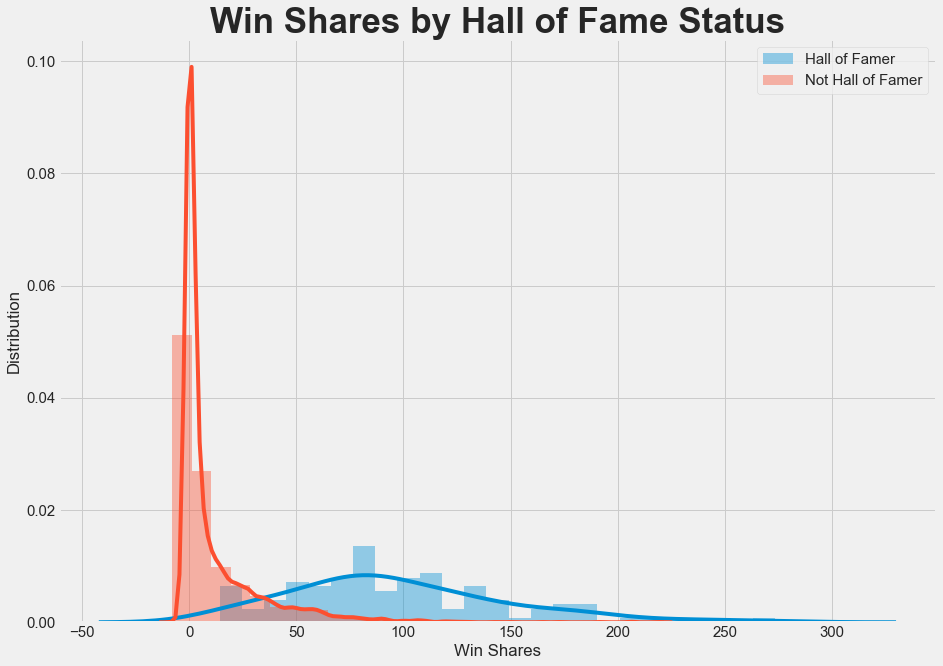

In [14]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['ws'], bins=25, label='Hall of Famer')
sns.distplot(players_not_hof['ws'].fillna(0), bins=25, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Win Shares")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Win Shares by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_ws.png')

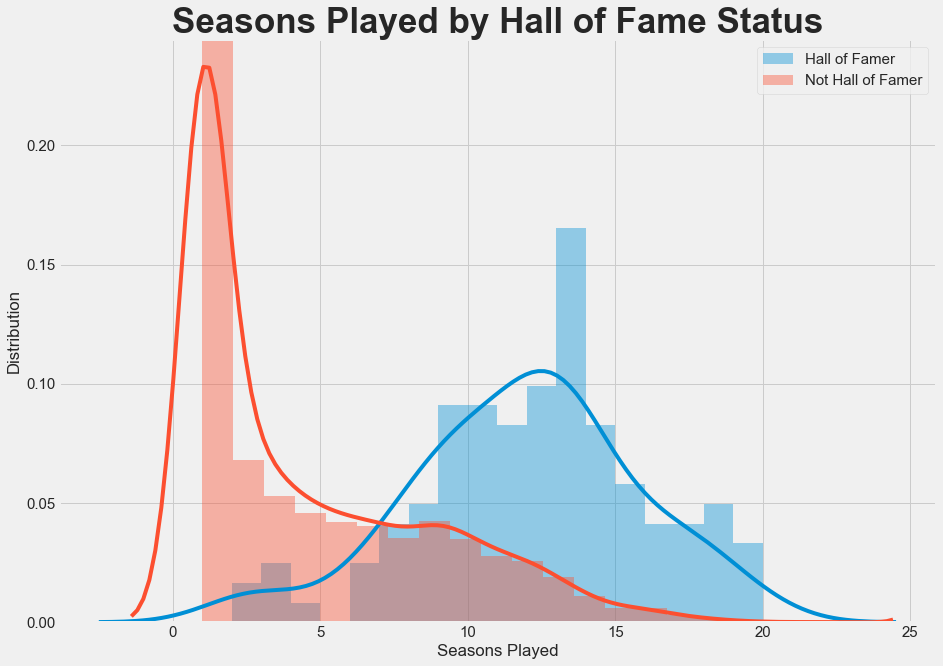

In [15]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,10))
sns.distplot(players_hof['career_length'], bins=18, label='Hall of Famer')
sns.distplot(players_not_hof['career_length'].fillna(0), bins=20, label='Not Hall of Famer')

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Seasons Played")
plt.ylabel("Distribution")
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Seasons Played by Hall of Fame Status', fontsize=35, fontweight="bold")

plt.savefig('all-graphs/hof_seasons_played.png')

## Model data for Machine Learning regression

In [16]:
players_feat = players[['career_length', 'position', 'trad_position', 
                        'ppg', 'trb', 'ast', 'fgp', 'per', 'ws', 'height_inches', 'weight', 'hof']].copy()
players_feat.head()

,career_length,position,trad_position,ppg,trb,ast,fgp,per,ws,height_inches,weight,hof
0,4,Power Forward,Forward,5.7,3.3,0.3,50.2,13.0,4.8,82.0,240.0,0.0
1,9,Power Forward,Forward,9.0,8.0,1.2,42.8,15.1,17.5,81.0,235.0,0.0
2,19,Center,Center,24.6,11.2,3.6,55.9,24.6,273.4,86.0,225.0,1.0
3,10,Point Guard,Guard,14.6,1.9,3.5,44.2,15.4,25.2,73.0,162.0,0.0
4,5,Shooting Guard,Guard,7.8,3.3,1.1,41.7,11.4,3.5,78.0,223.0,0.0


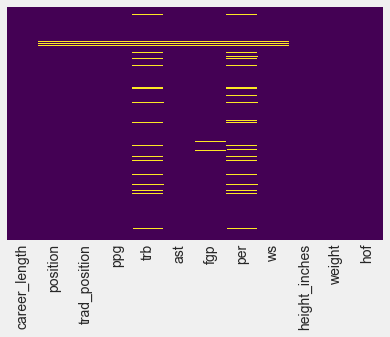

In [17]:
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

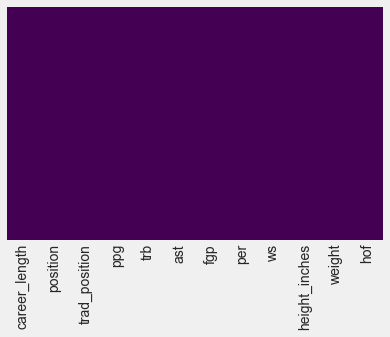

In [18]:
players_feat = players_feat.dropna() # delete rows with NaN values
sns.heatmap(players_feat.isnull(), yticklabels=False, cbar=False, cmap='viridis')

## Model data for Machine Learning regression

### Modern Five Positions

In [73]:
from sklearn.model_selection import train_test_split

X = players_feat[['career_length', 'ppg', 'trb', 'ast', 'fgp', 'per', 'ws', 'height_inches', 'weight']]
y = players_feat['position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

                precision    recall  f1-score   support

        Center       0.56      0.69      0.62       219
   Point Guard       0.71      0.76      0.74       251
 Power Forward       0.39      0.28      0.33       225
Shooting Guard       0.61      0.57      0.59       284
 Small Forward       0.49      0.51      0.50       269

   avg / total       0.56      0.57      0.56      1248



[[152   0  43   0  24]
 [  0 192   1  53   5]
 [ 91   0  64   0  70]
 [  0  69  11 162  42]
 [ 28   9  46  49 137]]


accuracy Score:  0.5665064102564102


<font color='blue'>Decision Tree Classifier</font>

In [31]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

                precision    recall  f1-score   support

        Center       0.64      0.60      0.62       219
   Point Guard       0.69      0.69      0.69       251
 Power Forward       0.44      0.48      0.46       225
Shooting Guard       0.51      0.52      0.52       284
 Small Forward       0.48      0.45      0.47       269

   avg / total       0.55      0.55      0.55      1248



[[131   2  77   1   8]
 [  1 173   0  69   8]
 [ 55   0 109   8  53]
 [  0  67   6 148  63]
 [ 18   8  57  64 122]]


accuracy Score:  0.5472756410256411


<font color='blue'>Naive Bayse Classifier</font>

In [32]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

                precision    recall  f1-score   support

        Center       0.79      0.65      0.71       219
   Point Guard       0.74      0.70      0.72       251
 Power Forward       0.51      0.62      0.56       225
Shooting Guard       0.59      0.56      0.57       284
 Small Forward       0.57      0.61      0.59       269

   avg / total       0.64      0.62      0.63      1248



[[142   0  71   0   6]
 [  0 176   0  71   4]
 [ 34   0 140   0  51]
 [  0  59   5 159  61]
 [  4   3  58  41 163]]


accuracy Score:  0.625


<font color='blue'>Support Vector Machine Classifier</font>

In [33]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

                precision    recall  f1-score   support

        Center       0.58      0.22      0.32       219
   Point Guard       0.59      0.30      0.40       251
 Power Forward       0.25      0.57      0.35       225
Shooting Guard       0.52      0.41      0.46       284
 Small Forward       0.43      0.47      0.45       269

   avg / total       0.47      0.40      0.40      1248



[[ 49   0 157   0  13]
 [  0  75  91  68  17]
 [ 32   0 128   3  62]
 [  0  44  47 116  77]
 [  4   8  94  37 126]]


accuracy Score:  0.3958333333333333


### Traditional Three Positions

In [34]:
X = players_feat[['ppg', 'trb', 'ast', 'height_inches', 'weight']]
y = players_feat['trad_position']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression Model</font>

In [35]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.68      0.33      0.45       215
    Forward       0.67      0.80      0.73       500
      Guard       0.87      0.89      0.88       533

avg / total       0.76      0.76      0.75      1248



[[ 72 140   3]
 [ 34 399  67]
 [  0  56 477]]


<font color='blue'>Decision Tree Classifier</font>

In [36]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.66      0.65      0.65       215
    Forward       0.71      0.72      0.71       500
      Guard       0.87      0.86      0.87       533

avg / total       0.77      0.77      0.77      1248



[[139  76   0]
 [ 73 358  69]
 [  0  72 461]]


<font color='blue'>Naive Bayse Classifier</font>

In [37]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

             precision    recall  f1-score   support

     Center       0.72      0.70      0.71       215
    Forward       0.74      0.77      0.75       500
      Guard       0.89      0.86      0.88       533

avg / total       0.80      0.80      0.80      1248



[[150  65   0]
 [ 58 384  58]
 [  0  72 461]]


<font color='blue'>Support Vector Machine Classifier</font>

In [38]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

     Center       0.72      0.52      0.61       215
    Forward       0.69      0.79      0.74       500
      Guard       0.88      0.85      0.87       533

avg / total       0.78      0.77      0.77      1248



[[112 103   0]
 [ 43 396  61]
 [  0  78 455]]


accuracy Score:  0.7716346153846154


### Predicting hall of fame status
#### By career length, points per game, total rebounds per game, and assists per game

Active players are incidated by '2018' in the active_to column. All active palyers also have 0 under hall-of-fame status, because to be considered for induction a player must be fully retired for at least three full seasons. This will skew the regression model, since it will interpretate that no current player, regardless of their career achievements, were deserving of the hall of fame status.

To get a more accurate interpretation of the hall of fame statuses, the data needs to be narrowed down to retired players who were eligible to be considered. All active players and anyone who retired after 2015 were excluded.

In [39]:
hof_eligible = players[players['active_to'] < 2015].dropna()

print("Correlation between career length and HOF: {}".format(hof_eligible['career_length'].corr(hof_eligible['hof'])))
print("Correlation between PPG and HOF: {}".format(hof_eligible['ppg'].corr(hof_eligible['hof'])))
print("Correlation between TRB and HOF: {}".format(hof_eligible['trb'].corr(hof_eligible['hof'])))
print("Correlation between AST and HOF: {}".format(hof_eligible['ast'].corr(hof_eligible['hof'])))
print("Correlation between PER and HOF: {}".format(hof_eligible['per'].corr(hof_eligible['per'])))
print("Correlation between WS and HOF: {}".format(hof_eligible['ws'].corr(hof_eligible['ws'])))

Correlation between career length and HOF: 0.3280495662008085
Correlation between PPG and HOF: 0.4845889282872929
Correlation between TRB and HOF: 0.40351326295279066
Correlation between AST and HOF: 0.34074647367188027
Correlation between PER and HOF: 1.0
Correlation between WS and HOF: 1.0


In [128]:
X = hof_eligible[['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
y = hof_eligible['hof']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Logistic Regression</font>

In [129]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions)) 

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       845
        1.0       0.80      0.52      0.63        31

avg / total       0.98      0.98      0.98       876



[[841   4]
 [ 15  16]]


accuracy Score:  0.978310502283105


<font color='blue'>Decision Tree Classifier</font>

In [130]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
predictions = dtree.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))   

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       845
        1.0       0.68      0.68      0.68        31

avg / total       0.98      0.98      0.98       876



[[835  10]
 [ 10  21]]


accuracy Score:  0.9771689497716894


<font color='blue'>Random Forest Classifier</font>

In [131]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       845
        1.0       0.68      0.68      0.68        31

avg / total       0.98      0.98      0.98       876



[[835  10]
 [ 10  21]]


accuracy Score:  0.9771689497716894


<font color='blue'>Naive Bayes Classifier</font>

In [43]:
model = GaussianNB()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

        0.0       1.00      0.93      0.96       843
        1.0       0.34      0.94      0.50        33

avg / total       0.97      0.93      0.94       876



[[783  60]
 [  2  31]]


accuracy Score:  0.9292237442922374


<font color='blue'>Support Vector Machine Classifier</font>

In [44]:
svc_model = SVC()
svc_model.fit(X_train,y_train)
predictions = svc_model.predict(X_test)

print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))
print('\n')
print('accuracy Score: ', accuracy_score(y_test, predictions))  

             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98       843
        1.0       0.00      0.00      0.00        33

avg / total       0.93      0.96      0.94       876



[[843   0]
 [ 33   0]]


accuracy Score:  0.9623287671232876


C:\Users\sonye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Using the model on current players to predict hall of fame status

Now we will look at players who either recently retired or currently playing in the league. We will try to predict, based on the models we ran above, if they will be inducted into the hall of fame based on their career average statistics. One important note is that since we are including career length as a factor, this model only focuses on on career achievements up to this point; it does not take account for a player's remaining seasons left in the league.

In [95]:
hof_not_eligible = players[players['active_to'] > 2015][['name', 'career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
hof_not_eligible = hof_not_eligible.sort_values(by='ppg', ascending=False)
hof_not_eligible = hof_not_eligible.dropna()
hof_not_eligible.head(10)

,name,career_length,ppg,trb,ast,per,ws
1963,LeBron James,14,27.2,7.4,7.2,27.7,219.4
1088,Kevin Durant,10,27.1,7.1,3.9,25.3,130.2
529,Kobe Bryant,19,25.0,5.2,4.7,22.9,172.7
107,Carmelo Anthony,14,24.1,6.5,3.0,20.3,100.7
902,Anthony Davis,5,23.4,10.3,1.9,27.1,62.5
869,Stephen Curry,8,23.1,4.4,6.8,23.8,93.3
2422,Damian Lillard,5,23.1,4.1,6.2,21.0,58.2
4319,Russell Westbrook,9,23.0,6.6,8.2,23.9,90.1
1631,James Harden,8,23.0,5.1,6.1,23.7,106.7
4193,Dwyane Wade,14,22.5,4.7,5.5,23.9,118.3


In [96]:
KB = hof_not_eligible[hof_not_eligible['name'] == 'Kobe Bryant'][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)
predictions = logmodel.predict_proba(KB)
predictions[0][1]
#model = SVC(probability=True)
#class_probabilities = model.predict_proba(sub_main)


0.9934862779575913

In [97]:
hof_list_log = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = logmodel.predict(player)
    hof_list_log.append(int(predictions))
hof_df_log = pd.DataFrame(hof_list_log)

hof_list_log_proba = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = logmodel.predict_proba(player)
    hof_list_log_proba.append(predictions[0][1])
hof_df_log_proba = pd.DataFrame(hof_list_log_proba)


In [98]:
hof_list_dtree = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = dtree.predict(player)
    hof_list_dtree.append(int(predictions))
hof_df_dtree = pd.DataFrame(hof_list_dtree)

hof_list_dtree_proba = []
for player in hof_not_eligible['name']:
    player = hof_not_eligible[hof_not_eligible['name'] == player][['career_length', 'ppg', 'trb', 'ast', 'per', 'ws']]
    predictions = dtree.predict_proba(player)
    hof_list_dtree_proba.append(predictions[0][1])
hof_df_dtree_proba = pd.DataFrame(hof_list_dtree_proba)

In [99]:
hof_not_eligible['hof_pred_log'] = pd.DataFrame(hof_df_log).values
hof_not_eligible['hof_pred_log_proba'] = pd.DataFrame(hof_df_log_proba).values
#hof_not_eligible['hof_pred_dtree'] = pd.DataFrame(hof_df_dtree).values
#hof_not_eligible['hof_pred_dtree_proba'] = pd.DataFrame(hof_df_dtree_proba).values
hof_not_eligible = hof_not_eligible.sort_values(by='hof_pred_log_proba', ascending=False)
hof_not_eligible.head()

,name,career_length,ppg,trb,ast,per,ws,hof_pred_log,hof_pred_log_proba
1963,LeBron James,14,27.2,7.4,7.2,27.7,219.4,1,0.999994
3152,Chris Paul,12,18.7,4.5,9.8,25.6,164.8,1,0.999691
1081,Tim Duncan,18,19.0,10.8,3.0,24.2,206.4,1,0.999476
3008,Dirk Nowitzki,19,21.2,7.7,2.5,22.6,206.1,1,0.998769
1373,Kevin Garnett,20,17.8,10.0,3.7,22.7,191.4,1,0.996822


In [100]:
hof_not_eligible.to_csv('Tables/hof_not_eligible.csv', index=False)

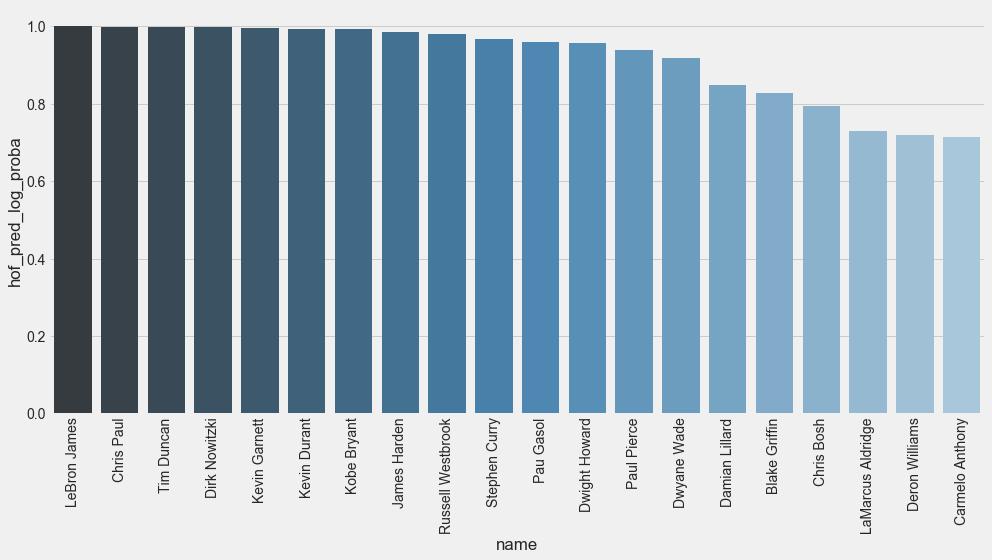

In [124]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,8))

#plt.figure(figsize=(16,12))

ax = sns.barplot(x='name', y='hof_pred_log_proba', data=hof_not_eligible[:20], palette="Blues_d")
ax.set_xticklabels(hof_not_eligible['name'],rotation=90)

plt.tight_layout()

plt.savefig('all-graphs/hof_pred.png')

### Year-by-year statistics

In [55]:
left_hand = []
right_hand = []
height = []
weight = []
ppg = []
trb = []
ast = []


start = players.active_from.min() # 1947 Season
end = players.active_from.max() # 2018 Season

for year in range(start,end):
    active = (players.active_from.values <= year) & (players.active_to >= year) # only include active players
    height.append(np.mean(players[active].height_inches)) # average height in inches
    weight.append(np.mean(players[active].weight)) # average weight in pounds
    left_hand.append(1.0*np.sum(players[active].shooting_hand == 'Left')) # number of left handed shooters
    right_hand.append(1.0*np.sum(players[active].shooting_hand == 'Right')) # number of right handed shooters
    ppg.append(np.mean(players[active].ppg))
    trb.append(np.mean(players[active].trb))
    ast.append(np.mean(players[active].ast))
    
# create a DataFrame with a summary
stats_year = pd.DataFrame({'season': np.arange(start,end), 
                          'height': height,
                          'weight': weight,
                          'left_hand': left_hand,
                          'right_hand': right_hand,
                          'ppg': ppg,
                          'trb': trb,
                          'ast': ast}).set_index('season')

# preview
stats_year.head()

,ast,height,left_hand,ppg,right_hand,trb,weight
season,,,,,,,
1947,0.748125,74.322981,4.0,5.051250,156.0,3.791304,188.656250
1948,1.157018,74.570175,2.0,6.642982,112.0,3.671875,187.362832
1949,1.400565,75.197740,6.0,6.537288,171.0,3.974603,191.536723
1950,1.728125,75.324444,5.0,7.046875,219.0,4.036066,191.493274
1951,1.932450,75.843137,6.0,8.190728,145.0,3.970199,194.549020


The per-season figures reflect the average statistical value for players who were active that year. It assumes that every player had a consistent height and weight for their entire careers, which is unlikely since players tend to be shortest/lightest their rookie years. It also assumes that players did not switch their shooting hands during their careers.

We can get more detailed season averages on [this page](http://en.wikipedia.org "Basketball Reference"), but for the purpose of this exercise we will use career averages for players active in each season

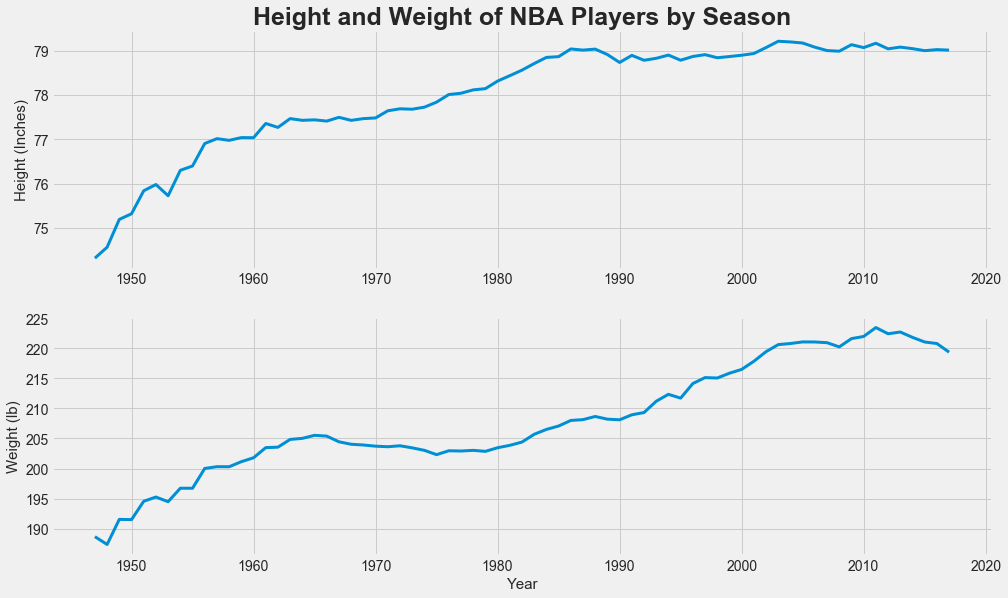

In [56]:
plt.style.use('fivethirtyeight')

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(15,9))

plt.subplot(2, 1, 1)
plt.title('Height and Weight of NBA Players by Season', fontsize = 25, fontweight='bold')
plt.plot(stats_year['height'], linewidth=3.0)
plt.ylabel("Height (Inches)", fontsize=15)

plt.subplot(2, 1, 2)
plt.plot(stats_year['weight'], linewidth=3.0)
plt.ylabel('Weight (lb)', fontsize=15)
plt.xlabel('Year', fontsize=15)

plt.savefig('all-graphs/yoy_weight_weight.png')

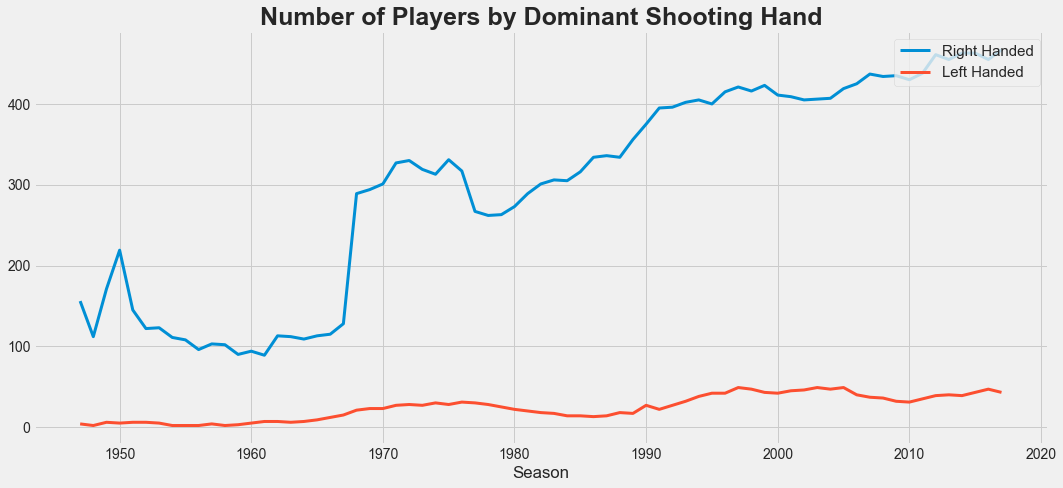

In [57]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(14,7))

stats_year['right_hand'].plot(figsize=(15,7), label='Right Handed', linewidth=3.0)
stats_year['left_hand'].plot(label='Left Handed', linewidth=3.0)

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Season")
plt.title('Number of Players by Dominant Shooting Hand', fontsize = 25, fontweight='bold')

plt.tight_layout()

plt.savefig('all-graphs/yoy_left_right.png')

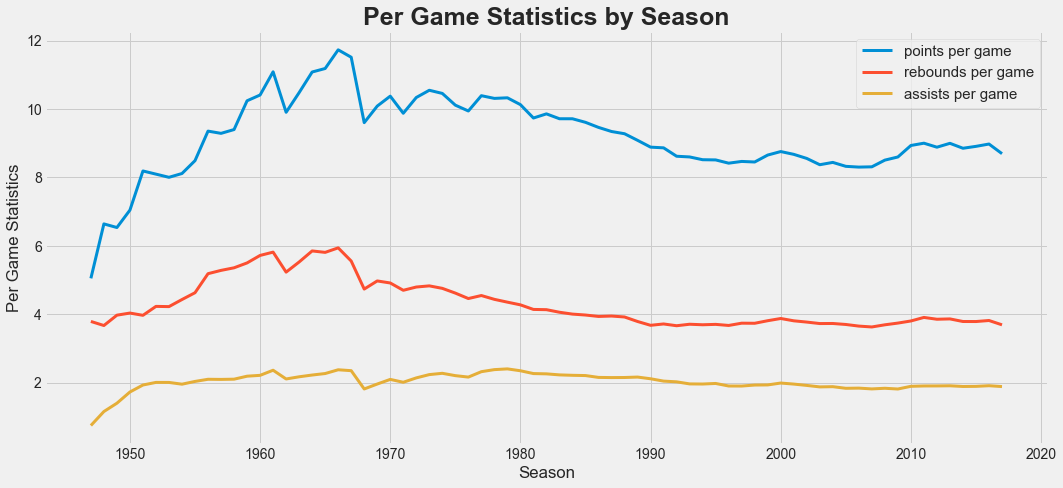

In [58]:
plt.style.use('fivethirtyeight')

stats_year['ppg'].plot(figsize=(15,7), label='points per game', linewidth=3.0)
stats_year['trb'].plot(label='rebounds per game', linewidth=3.0)
stats_year['ast'].plot(label='assists per game', linewidth=3.0)

plt.legend(loc=1, frameon=True, prop={'size': 15})
plt.xlabel("Season")
plt.ylabel("Per Game Statistics")
plt.title('Per Game Statistics by Season', fontsize = 25, fontweight='bold')

plt.tight_layout()

plt.savefig('all-graphs/yoy_ppg_trb_ast.png')

### Predicting Height by year

In [59]:
X = stats_year.drop('height', axis=1)
y = stats_year['height']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

<font color='blue'>Linear Regression Model</font>

In [60]:
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

print("R2 Score: ", lm.score(X_test, y_test))

R2 Score:  0.9284532767065335


In [61]:
predictions

array([78.75959166, 77.27957928, 78.66067058, 79.51767812, 77.5538923 ,
       79.24649062, 78.21382731, 77.92877683, 77.25265276, 78.68003689,
       77.69609023, 79.54317451, 78.39950754, 76.91275709, 79.3213917 ,
       78.68514146, 76.41194164, 76.6874756 , 79.60764408, 76.02314918,
       77.40425522, 78.92916423])

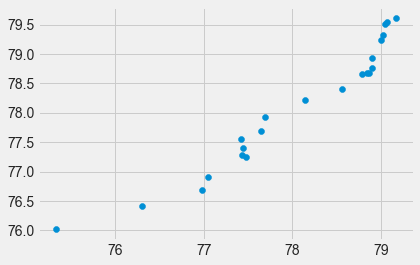

In [62]:
plt.scatter(y_test, predictions) ## y_test contains the contain ppg averages year-by-year

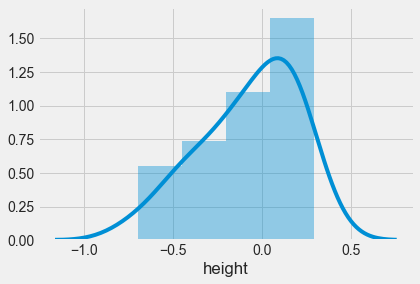

In [63]:
sns.distplot(y_test - predictions) # histogram of the residuals